In [4]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Notebook magic
%matplotlib inline

In [2]:
import splitfolders

In [2]:
import splitfolders
input_folder = "Sample"
splitfolders.ratio(input_folder, output="dataset", seed=100, ratio=(0.6, 0.2, 0.2), group_prefix=None)

In [3]:
# Configure variables for Transfer learning
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

In [4]:
dataset_root = r"C:\Users\DELL\Downloads\MyPlant\dataset"

train_dir = os.path.join(dataset_root, "train")
test_dir = os.path.join(dataset_root, "val")

In [5]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2,
)

# Read data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 8876 images belonging to 17 classes.


In [6]:
# Get the list of categories in training data
cats = list(train_data.class_indices.keys())

print(cats)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy']


In [10]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 2956 images belonging to 17 classes.


In [11]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

In [12]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 17)                21777     
                                                                 
Total params: 2,279,761
Trainable params: 21,777
Non-traina

In [13]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [14]:
# Num epochs
epochs = 5

# Train model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs,
    batch_size=batch_size,
    validation_batch_size=batch_size,
    callbacks=[early_stopping_cb]
)

Epoch 1/5
278/278 [==============================] - 522s 2s/step - loss: 0.6936 - accuracy: 0.7945 - val_loss: 0.2355 - val_accuracy: 0.9364
Epoch 2/5
278/278 [==============================] - 435s 2s/step - loss: 0.2427 - accuracy: 0.9299 - val_loss: 0.1562 - val_accuracy: 0.9520
Epoch 3/5
278/278 [==============================] - 448s 2s/step - loss: 0.1842 - accuracy: 0.9394 - val_loss: 0.1438 - val_accuracy: 0.9547
Epoch 4/5
278/278 [==============================] - 442s 2s/step - loss: 0.1522 - accuracy: 0.9503 - val_loss: 0.1195 - val_accuracy: 0.9611
Epoch 5/5
278/278 [==============================] - 436s 2s/step - loss: 0.1318 - accuracy: 0.9557 - val_loss: 0.1217 - val_accuracy: 0.9594


In [15]:
model.evaluate(test_data)

93/93 [==============================] - 87s 930ms/step - loss: 0.1217 - accuracy: 0.9594


[0.12173102796077728, 0.9594045877456665]

In [17]:
model.save("Model_1.h5")

In [3]:
from keras.models import load_model
import cv2
import numpy as np

model = load_model('Model_1.h5')

# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
classes=list(train_data.class_indices.keys())
img = cv2.imread('image (132).jpg')
img = cv2.resize(img,(224,224))
img = np.reshape(img,[1,224,224,3])
img = img/255.0

predict = model.predict(img)
result = np.argmax(predict,axis=1)
print(classes[result[0]])

OSError: No file or directory found at Model_1.h5

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpse0xyl58\assets


INFO:tensorflow:Assets written to: C:\Users\DELL\AppData\Local\Temp\tmpse0xyl58\assets


In [33]:
import pathlib
tflite_model_file = pathlib.Path('./Model/Model_1.tflite')
tflite_model_file.write_bytes(tflite_model)

8952352

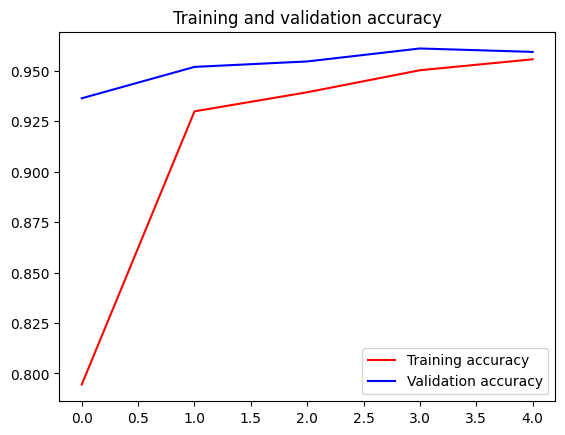

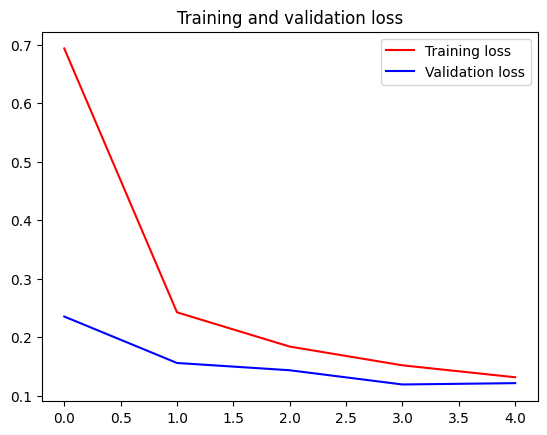

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()